# Backpropagation in Multilayer Neural Networks

### Goals: 
- implementING a real gradient descent in `Numpy`

### Dataset:
- Similar as first Tutorial - Digits: 10 class handwritten digits
- [sklearn.datasets.load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

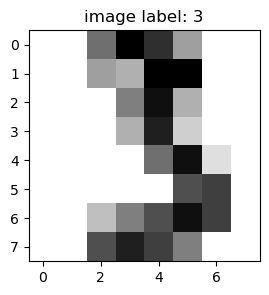

In [2]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- Normalization
- Train / test split

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(scaler.mean_)
print(scaler.scale_)

[0.00000000e+00 2.98624754e-01 5.19253438e+00 1.18428291e+01
 1.18565815e+01 5.81008513e+00 1.34774067e+00 1.19187950e-01
 6.54878847e-03 1.99345121e+00 1.03464309e+01 1.19305828e+01
 1.02626064e+01 8.20497708e+00 1.84348396e+00 9.88867060e-02
 3.27439424e-03 2.61624100e+00 9.83497053e+00 6.87098887e+00
 7.11263916e+00 7.83759005e+00 1.75376555e+00 4.45317616e-02
 1.30975769e-03 2.48788474e+00 9.04453176e+00 8.73280943e+00
 9.98231827e+00 7.57105435e+00 2.26850033e+00 2.61951539e-03
 0.00000000e+00 2.36149312e+00 7.68369352e+00 9.07924034e+00
 1.03713163e+01 8.79240341e+00 2.89980354e+00 0.00000000e+00
 8.51342502e-03 1.57039948e+00 6.84937787e+00 7.22855272e+00
 7.65029470e+00 8.26522593e+00 3.48592010e+00 2.61951539e-02
 8.51342502e-03 6.83693517e-01 7.49312377e+00 9.56516045e+00
 9.36869679e+00 8.77668631e+00 3.76686313e+00 2.08906352e-01
 6.54878847e-04 2.78978389e-01 5.53700065e+00 1.20595940e+01
 1.17832351e+01 6.81990832e+00 2.07465619e+00 3.42501637e-01]
[1.         0.91047427 

In [4]:
X_train.shape

(1527, 64)

In [5]:
X_train.dtype

dtype('float32')

In [6]:
X_test.shape

(270, 64)

In [7]:
y_train.shape

(1527,)

In [8]:
y_train.dtype

dtype('int32')

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement a simple forward model with no hidden layer (equivalent to a logistic regression):
note: shape, transpose of W with regards to course
$y = softmax(\mathbf{W} \dot x + b)$

- Build a predict function which returns the most probable class given an input $x$

- Build an accuracy function for a batch of inputs $X$ and the corresponding expected outputs $y_{true}$

- Build a grad function which computes $\frac{d}{dW} -\log(softmax(W \dot x + b))$ for an $x$ and its corresponding expected output $y_{true}$ ; check that the gradients are well defined

- Build a train function which uses the grad function output to update $\mathbf{W}$ and $b$


### One-hot encoding for class label data

First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes (similar to keras' `to_categorical`):

In [9]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [10]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [11]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [12]:
def softmax(X):
    exp= np.exp(X - np.max(X, axis=-1, keepdims=True))
    return exp / np.sum(exp, axis=-1, keepdims=True)

Make sure that this works one vector at a time (and check that the components sum to one):

In [13]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


Note that a naive implementation of softmax might not be able process a batch of activations in a single call:

In [14]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Here is a way to implement softmax that works both for an individual vector of activations and for a batch of activation vectors at once:

In [15]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)


print("softmax of a single vector:")
print(softmax([10, 2, -3]))

softmax of a single vector:
[9.99662391e-01 3.35349373e-04 2.25956630e-06]


Probabilities should sum to 1:

In [16]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [17]:
print("sotfmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

sotfmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [18]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Implement a function that given the true one-hot encoded class `Y_true` and and some predicted probabilities `Y_pred` returns the negative log likelihood.

In [19]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    eps = 1e-8 
    return -np.sum(Y_true * np.log(Y_pred + eps)) / Y_true.shape[0]


# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.003350108584163783


Check that the nll of a very confident yet bad prediction is a much higher positive number:

In [20]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

1.5350563953295306


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [25]:
eps = 1e-8 
def nll(Y_true, Y_pred):
    Y_true = np.atleast_2d(Y_true)
    Y_pred = np.atleast_2d(Y_pred)
    
    return -np.sum(Y_true * np.log(Y_pred +  eps)) / Y_true.shape[0]


In [26]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.0033501019174971905


Let us now study the following linear model trainable by SGD, **one sample at a time**.

In [27]:
class LogisticRegression():

    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size
        
    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        # Traditional SGD update without momentum
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"]
        self.b = self.b - learning_rate * grads["b"]      
        
    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [28]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 2.4037, train acc: 0.141, test acc: 0.122


Evaluate the randomly initialized model on the first example:

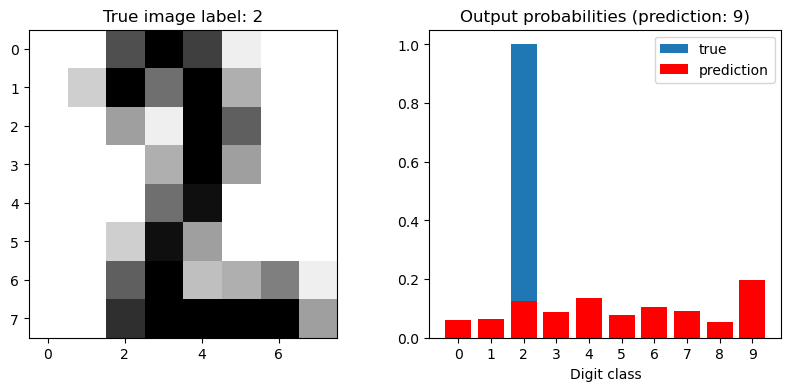

In [29]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(scaler.inverse_transform(X_test[sample_idx:sample_idx+1]).reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
plot_prediction(lr, sample_idx=0)

In [30]:
# Training for one epoch
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)
        print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
              % (i, train_loss, train_acc, test_acc))

Update #0, train loss: 2.3710, train acc: 0.162, test acc: 0.156
Update #100, train loss: 1.3005, train acc: 0.687, test acc: 0.715
Update #200, train loss: 0.8539, train acc: 0.853, test acc: 0.863
Update #300, train loss: 0.6401, train acc: 0.902, test acc: 0.896
Update #400, train loss: 0.5331, train acc: 0.903, test acc: 0.911
Update #500, train loss: 0.4639, train acc: 0.912, test acc: 0.919
Update #600, train loss: 0.4030, train acc: 0.929, test acc: 0.922
Update #700, train loss: 0.3660, train acc: 0.935, test acc: 0.944
Update #800, train loss: 0.3445, train acc: 0.936, test acc: 0.944
Update #900, train loss: 0.3212, train acc: 0.940, test acc: 0.948
Update #1000, train loss: 0.3014, train acc: 0.948, test acc: 0.952
Update #1100, train loss: 0.2836, train acc: 0.944, test acc: 0.959
Update #1200, train loss: 0.2731, train acc: 0.948, test acc: 0.959
Update #1300, train loss: 0.2608, train acc: 0.950, test acc: 0.952
Update #1400, train loss: 0.2494, train acc: 0.950, test acc

Evaluate the trained model on the first example:

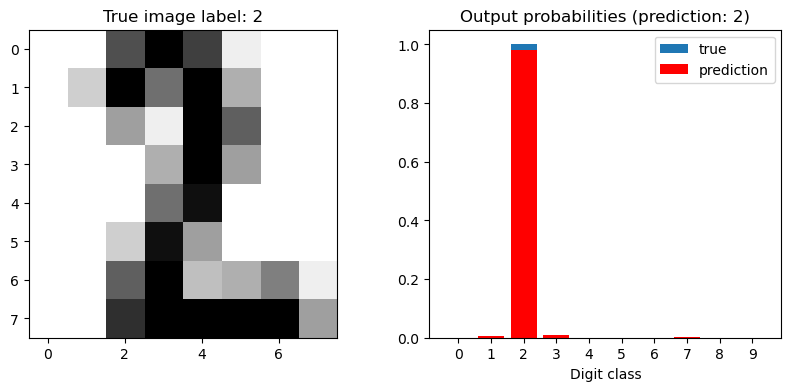

In [31]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

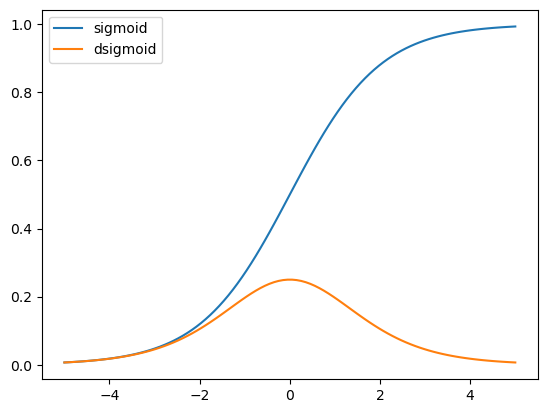

In [32]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))


def dsigmoid(X):
    s = sigmoid(X)
    return  s * (1 - s)


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

- Implement `forward` and `forward_keep_all` functions for a model with a hidden layer with a sigmoid activation function:
  - $\mathbf{h} = sigmoid(\mathbf{W}^h \mathbf{x} + \mathbf{b^h})$
  - $\mathbf{y} = softmax(\mathbf{W}^o \mathbf{h} + \mathbf{b^o})$

- Notes: 
  - try to keep the code as similar as possible as the previous one;
  - `forward` now has a keep activations parameter to also return hidden activations and pre activations;

- Update the grad function to compute all gradients; check that the gradients are well defined;

- Implement the `train` and `loss` functions.

**Bonus**: reimplementing all from scratch only using the lecture slides but without looking at the solution of the `LogisticRegression` is an excellent exercise.

In [33]:
EPSILON = 1e-8


class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""
    
    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(size=(input_size, hidden_size), high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size, high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size), high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size, high=0.1, low=-0.1)
        self.output_size = output_size
            
    def forward_keep_activations(self, X):
        z_h = np.dot(X, self.W_h) + self.b_h  
        h = sigmoid(z_h) 
        z_o = np.dot(h, self.W_o) + self.b_o  
        y = softmax(z_o)  
        return y, h, z_h

    def forward(self, X):
        y, h, z_h = self.forward_keep_activations(X)
        return y
    
    def loss(self, X, y):
         return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, x, y_true):
        y_pred, h, z_h = self.forward_keep_activations(x)
        
        # Calculate gradients
        dnll_output = y_pred - one_hot(self.output_size, y_true)
        grad_W_o = np.outer(h, dnll_output)
        grad_b_o = dnll_output
        
        # Backprop to hidden layer
        dh = np.dot(dnll_output, self.W_o.T) * dsigmoid(z_h)
        grad_W_h = np.outer(x, dh)
        grad_b_h = dh
        
        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        grads = self.grad_loss(x, y)
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [32]:
# Verify your solution by the tutor

In [34]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [35]:
model.loss(X_train, y_train)

2.309473980627036

In [36]:
model.accuracy(X_train, y_train)

0.10347085789129011

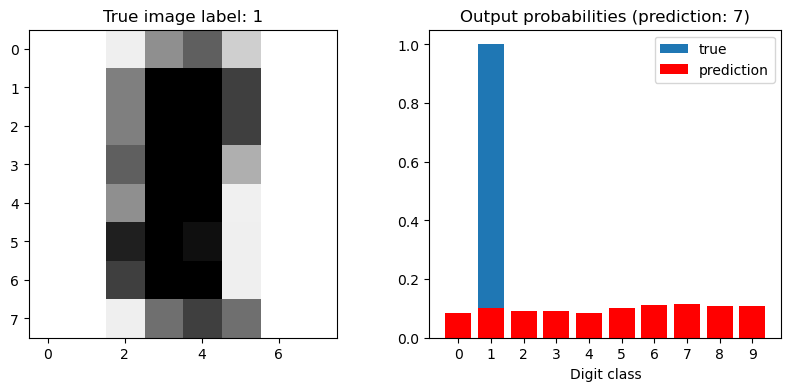

In [37]:
plot_prediction(model, sample_idx=5)

In [38]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 2.30947, train acc: 0.103, test acc: 0.074
Epoch #1, train loss: 0.31158, train acc: 0.925, test acc: 0.904
Epoch #2, train loss: 0.16621, train acc: 0.964, test acc: 0.941
Epoch #3, train loss: 0.12130, train acc: 0.972, test acc: 0.926
Epoch #4, train loss: 0.09185, train acc: 0.980, test acc: 0.937
Epoch #5, train loss: 0.07158, train acc: 0.986, test acc: 0.948
Epoch #6, train loss: 0.05842, train acc: 0.989, test acc: 0.952
Epoch #7, train loss: 0.04967, train acc: 0.993, test acc: 0.956
Epoch #8, train loss: 0.04226, train acc: 0.995, test acc: 0.944
Epoch #9, train loss: 0.03653, train acc: 0.995, test acc: 0.956
Epoch #10, train loss: 0.03273, train acc: 0.995, test acc: 0.956
Epoch #11, train loss: 0.02970, train acc: 0.995, test acc: 0.952
Epoch #12, train loss: 0.02731, train acc: 0.996, test acc: 0.952
Epoch #13, train loss: 0.02523, train acc: 0.996, test acc: 0.948
Epoch #14, train loss: 0.02341, train acc: 0.996, test acc: 0.948
Epoch #15, train 

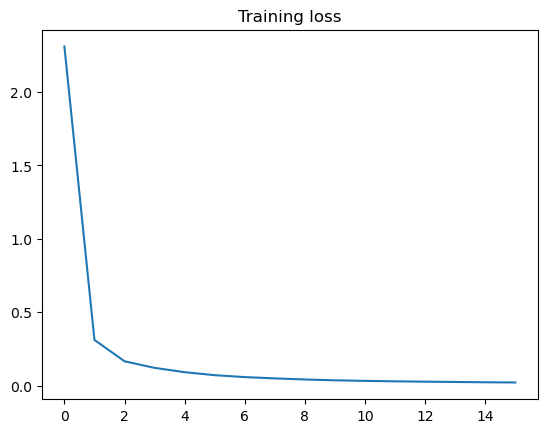

In [39]:
plt.plot(losses)
plt.title("Training loss");

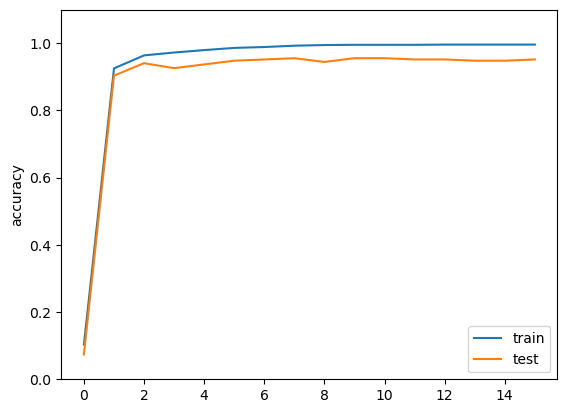

In [40]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

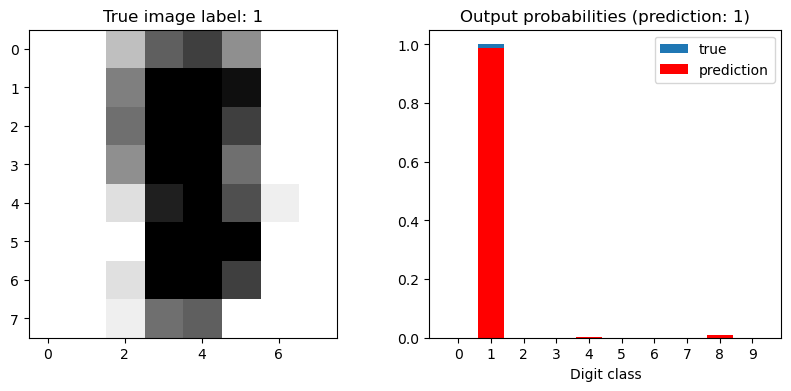

In [41]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

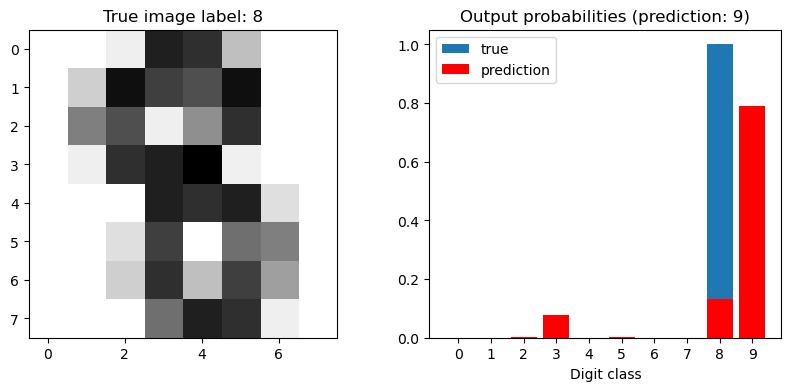

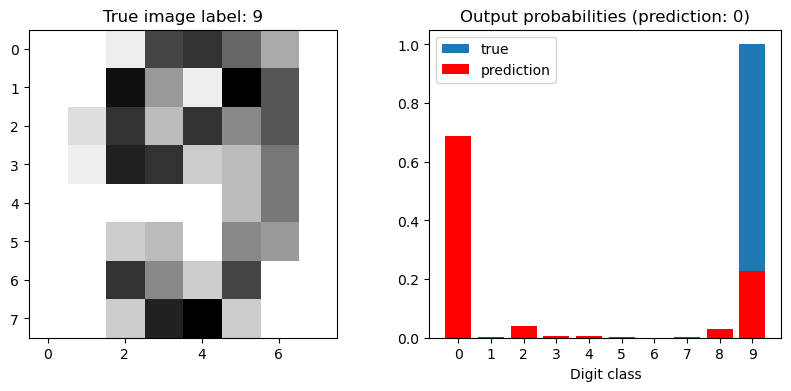

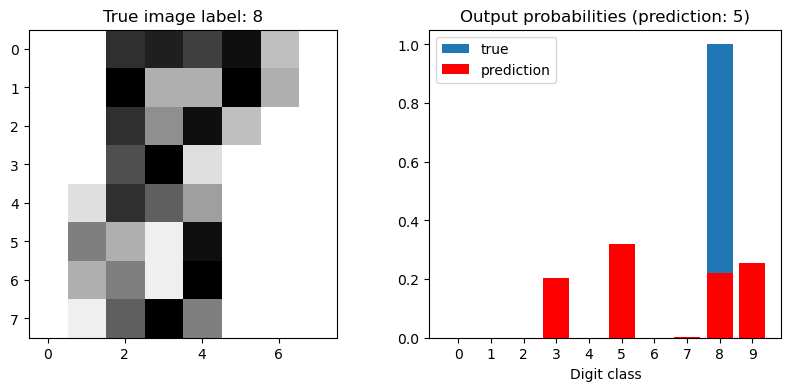

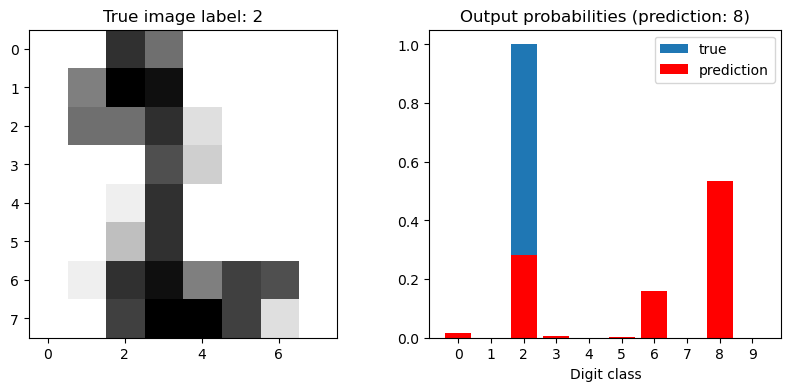

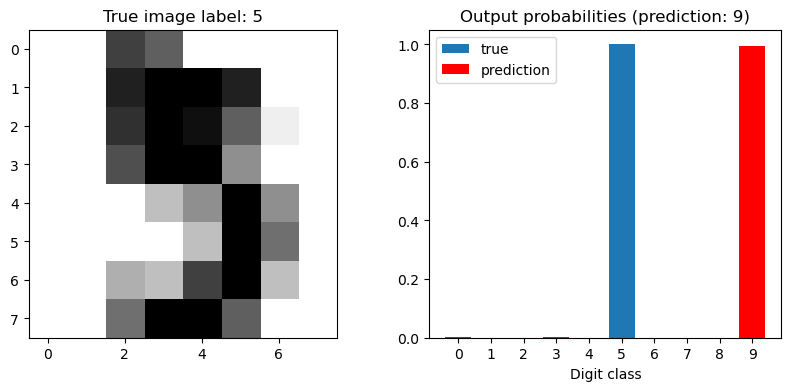

In [42]:
y_preds = model.predict(X_test)
incorrect_indices = np.where(y_preds != y_test)[0]

num_samples = 5
worst_samples = incorrect_indices[:num_samples]
for idx in worst_samples:
    plot_prediction(model, sample_idx=idx)

### Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - initialization scheme: test with 0 initialization vs uniform,
  - implement other activation functions,
  - implement the support for a second hidden layer.


### Mini-batches

- The current implementations of `train` and `grad_loss` function currently only accept a single sample at a time:
    - implement the support for training with a mini-batch of 32 samples at a time instead of one,
    - experiment with different sizes of batches,
    - monitor the norm of the average gradients on the full training set at the end of each epoch.


### Momentum

- Bonus: Implement momentum


### Back to Keras

- Implement the same network architecture with Keras;

- Check that the Keras model can approximately reproduce the behavior of the Numpy model when using similar hyperparameter values (size of the model, type of activations, learning rate value and use of momentum);

- Compute the negative log likelihood of a sample 42 in the test set (can use `model.predict_proba`);

- Compute the average negative log-likelihood on the full test set.

- Compute the average negative log-likelihood  on the full training set and check that you can get the value of the loss reported by Keras.

- Is the model overfitting or underfitting? (ensure that the model has fully converged by increasing the number of epochs to 50 or more if necessary).

In [44]:
# Verify your solution by the tutor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(n_hidden, input_dim=n_features, activation='sigmoid'))
model.add(Dense(n_classes, activation='softmax'))

sgd = SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.fit(X_train, one_hot(n_classes, y_train), epochs=50, batch_size=32)




Epoch 1/50


48/48 [==============================] - 1s 5ms/step - loss: 1.5598 - accuracy: 0.5900
Epoch 2/50
48/48 [==============================] - 0s 3ms/step - loss: 0.5300 - accuracy: 0.9188
Epoch 3/50
48/48 [==============================] - 0s 2ms/step - loss: 0.2884 - accuracy: 0.9535
Epoch 4/50
48/48 [==============================] - 0s 2ms/step - loss: 0.2024 - accuracy: 0.9659
Epoch 5/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1614 - accuracy: 0.9784
Epoch 6/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1322 - accuracy: 0.9823
Epoch 7/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1137 - accuracy: 0.9862
Epoch 8/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1020 - accuracy: 0.9882
Epoch 9/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0903 - accuracy: 0.9889
Epoch 10/50
48/48 [==============================] - 0s 3ms/step - loss: 0.0825 - accuracy: 0.9882
Epoch 11/50
48/

In [46]:
# Verify your solution by the tutor
sample_pred = model.predict(X_test[42:43])
sample_true = one_hot(n_classes, y_test[42])
nll_sample = -np.sum(sample_true * np.log(sample_pred))
print("NLL for sample 42: ", nll_sample)


1/1 [==============================] - 0s 128ms/step
NLL for sample 42:  0.000496868509799242


In [47]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
nll_test = -np.mean(np.sum(one_hot(n_classes, y_test) * np.log(test_pred), axis=1))
nll_train = -np.mean(np.sum(one_hot(n_classes, y_train) * np.log(train_pred), axis=1))
print("Average NLL on test set: ", nll_test)
print("Average NLL on training set: ", nll_train)


48/48 [==============================] - 0s 2ms/step
Average NLL on test set:  0.1060750798501195
Average NLL on training set:  0.013406489433841698


## Homework assignments

- Watch the following video on [how to code a minimal deep learning framework](https://www.youtube.com/watch?v=o64FV-ez6Gw) that feels like a simplified version
of Keras but using numpy instead of tensorflow:

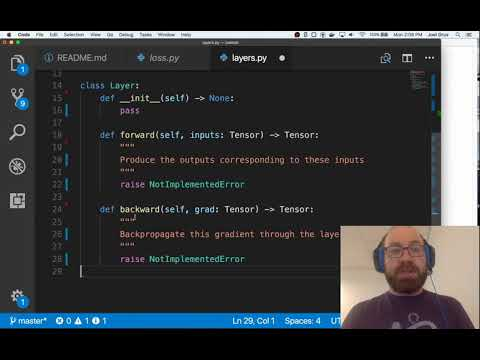

In [48]:
from IPython.display import YouTubeVideo
YouTubeVideo("o64FV-ez6Gw")

- **Optional**: read the following blog post on Reverse-Mode Automatic Differentiation from start to section "A simple implementation in Python" included:

  https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation